<a href="https://colab.research.google.com/github/yejoonlee/TSA_Practice/blob/main/3_Evaluation_and_ErrorAnalysis_with_BaseModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 해당 파일은 간단하게 모델링 된 결과를 분석하는 방식에 대해 다룰 것이다.

## **0. From data load to modeling**
이전 실습 내용과 간단한 선형회귀 모델로 예측을 진행하여 그 결과로 해당 파일에서 실습하고자 하는 부분을 준비한다.

- Data Loading

In [5]:
!python -m pip install --user --upgrade pip

In [2]:
# Ignore the warnings
import warnings
# warnings.filterwarnings('always')
warnings.filterwarnings('ignore')

# System related and data input controls
import os

# Data manipulation and visualization
import pandas as pd
pd.options.display.float_format = '{:,.2f}'.format
pd.options.display.max_rows = 10
pd.options.display.max_columns = 20
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Modeling algorithms
# General
import statsmodels.api as sm
from scipy import stats

# Model selection
from sklearn.model_selection import train_test_split

# Evaluation metrics
# for regression
from sklearn.metrics import mean_squared_log_error, mean_squared_error,  r2_score, mean_absolute_error

In [3]:
# mount google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# copy the path to data and read by pandas
location = '/content/drive/MyDrive/Colab Notebooks/practice/TSA_Practice/Data/BikeSharingDemand/Bike_Sharing_Demand_Full.csv'
raw_all = pd.read_csv(location)
raw_all

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 0:00,1,0,0,1,9.84,14.39,81,0.00,3,13,16
1,2011-01-01 1:00,1,0,0,1,9.02,13.63,80,0.00,8,32,40
2,2011-01-01 2:00,1,0,0,1,9.02,13.63,80,0.00,5,27,32
3,2011-01-01 3:00,1,0,0,1,9.84,14.39,75,0.00,3,10,13
4,2011-01-01 4:00,1,0,0,1,9.84,14.39,75,0.00,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
17374,2012-12-31 19:00,1,0,1,2,10.66,12.88,60,11.00,11,108,119
17375,2012-12-31 20:00,1,0,1,2,10.66,12.88,60,11.00,8,81,89
17376,2012-12-31 21:00,1,0,1,1,10.66,12.88,60,11.00,7,83,90
17377,2012-12-31 22:00,1,0,1,1,10.66,13.63,56,9.00,13,48,61


- Feature Engineering

In [6]:
### Feature engineering of all
def feature_engineering(raw):
    raw_fe = raw.copy()
    if 'datetime' in raw_fe.columns:
        raw_fe['datetime'] = pd.to_datetime(raw_fe['datetime'])
        raw_fe['DateTime'] = pd.to_datetime(raw_fe['datetime'])

    if raw_fe.index.dtype == 'int64':
        raw_fe.set_index('DateTime', inplace=True)

    raw_fe = raw_fe.asfreq('H', method='ffill')

    result = sm.tsa.seasonal_decompose(raw_fe['count'], model='additive')
    Y_trend = pd.DataFrame(result.trend)
    Y_trend.fillna(method='ffill', inplace=True)
    Y_trend.fillna(method='bfill', inplace=True)
    Y_trend.columns = ['count_trend']
    Y_seasonal = pd.DataFrame(result.seasonal)
    Y_seasonal.fillna(method='ffill', inplace=True)
    Y_seasonal.fillna(method='bfill', inplace=True)
    Y_seasonal.columns = ['count_seasonal']
    pd.concat([raw_fe, Y_trend, Y_seasonal], axis=1).isnull().sum()
    if 'count_trend' not in raw_fe.columns:
        if 'count_seasonal' not in raw_fe.columns:
            raw_fe = pd.concat([raw_fe, Y_trend, Y_seasonal], axis=1)

    Y_count_Day = raw_fe[['count']].rolling(24).mean()
    Y_count_Day.fillna(method='ffill', inplace=True)
    Y_count_Day.fillna(method='bfill', inplace=True)
    Y_count_Day.columns = ['count_Day']
    Y_count_Week = raw_fe[['count']].rolling(24*7).mean()
    Y_count_Week.fillna(method='ffill', inplace=True)
    Y_count_Week.fillna(method='bfill', inplace=True)
    Y_count_Week.columns = ['count_Week']
    if 'count_Day' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_count_Day], axis=1)
    if 'count_Week' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_count_Week], axis=1)

    Y_diff = raw_fe[['count']].diff()
    Y_diff.fillna(method='ffill', inplace=True)
    Y_diff.fillna(method='bfill', inplace=True)
    Y_diff.columns = ['count_diff']
    if 'count_diff' not in raw_fe.columns:
        raw_fe = pd.concat([raw_fe, Y_diff], axis=1)

    raw_fe['temp_group'] = pd.cut(raw_fe['temp'], 10)
    raw_fe['Year'] = raw_fe.datetime.dt.year
    raw_fe['Quater'] = raw_fe.datetime.dt.quarter
    raw_fe['Quater_ver2'] = raw_fe['Quater'] + (raw_fe.Year - raw_fe.Year.min()) * 4
    raw_fe['Month'] = raw_fe.datetime.dt.month
    raw_fe['Day'] = raw_fe.datetime.dt.day
    raw_fe['Hour'] = raw_fe.datetime.dt.hour
    raw_fe['DayofWeek'] = raw_fe.datetime.dt.dayofweek

    raw_fe['count_lag1'] = raw_fe['count'].shift(1)
    raw_fe['count_lag2'] = raw_fe['count'].shift(2)
    raw_fe['count_lag1'].fillna(method='bfill', inplace=True)
    raw_fe['count_lag2'].fillna(method='bfill', inplace=True)

    if 'Quater' in raw_fe.columns:
        if 'Quater_Dummy' not in ['_'.join(col.split('_')[:2]) for col in raw_fe.columns]:
            raw_fe = pd.concat([raw_fe, pd.get_dummies(raw_fe['Quater'], prefix='Quater_Dummy', drop_first=True)], axis=1)
            del raw_fe['Quater']
    return raw_fe
    
raw_fe = feature_engineering(raw_all)

- Data Split to train & test

In [7]:
# 시계열 데이터의 경우 일반적인 분석과 같이 정해둔 사이즈 만큼 랜덤 샘플링하여 train, test를 나누지 않고
# 원하는 시간을 기준으로 기준 시간 앞으로는 train, 이후로는 test로 사용하게된다.

### Data split of cross sectional
def datasplit_cs(raw, Y_colname, X_colname, test_size, random_seed=123):
    X_train, X_test, Y_train, Y_test = train_test_split(raw[X_colname], raw[Y_colname], test_size=test_size, random_state=random_seed)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_cs(raw_fe, Y_colname, X_colname, 0.2)


### Data split of time series
def datasplit_ts(raw, Y_colname, X_colname, criteria):
    raw_train = raw.loc[raw.index < criteria,:]
    raw_test = raw.loc[raw.index >= criteria,:]
    Y_train = raw_train[Y_colname]
    X_train = raw_train[X_colname]
    Y_test = raw_test[Y_colname]
    X_test = raw_test[X_colname]
    print('Train_size:', raw_train.shape, 'Test_size:', raw_test.shape)
    print('X_train:', X_train.shape, 'Y_train:', Y_train.shape)
    print('X_test:', X_test.shape, 'Y_test:', Y_test.shape)
    return X_train, X_test, Y_train, Y_test
# X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')

# Confirm of input and output
Y_colname = ['count']
X_remove = ['datetime', 'DateTime', 'temp_group', 'casual', 'registered']
X_colname = [x for x in raw_fe.columns if x not in Y_colname+X_remove]
X_train, X_test, Y_train, Y_test = datasplit_ts(raw_fe, Y_colname, X_colname, '2012-07-01')

Train_size: (13128, 29) Test_size: (4416, 29)
X_train: (13128, 24) Y_train: (13128, 1)
X_test: (4416, 24) Y_test: (4416, 1)


- Applying Base Model

In [8]:
# LinearRegression (using statsmodels)
fit_reg1 = sm.OLS(Y_train, X_train).fit()
display(fit_reg1.summary())
pred_tr_reg1 = fit_reg1.predict(X_train).values
pred_te_reg1 = fit_reg1.predict(X_test).values

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  count   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 3.362e+08
Date:                Wed, 22 Dec 2021   Prob (F-statistic):               0.00
Time:                        14:03:08   Log-Likelihood:                 1906.2
No. Observations:               13128   AIC:                            -3764.
Df Residuals:                   13104   BIC:                            -3585.
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
season            -0.0005      0.004     -0.129      0.897      -0.009       0.008
holiday            0.0083      0.014      0.612      0.540      -0.018       0.035
workingday         0.0079      0.007      1.184      0.236      -0.005       0.021
weather            0.0042      0.003      1.232      0.218      -0.003       0.011
temp               0.0022      0.002      1.075      0.282      -0.002       0.006
atemp             -0.0025      0.002     -1.347      0.178      -0.006       0.001
humidity          -0.0001      0.000     -0.845      0.398      -0.000       0.000
windspeed          0.0003      0.000      1.062      0.288      -0.000       0.001
count_trend     9.161e-05   8.57e-05      1.069      0.285   -7.64e-05       0.000
count_seasonal  1.984e-05   2.56e-05      0.775      0.438   -3.03e-05       7e-05
count_Day       4.177e-05   8.36e-05      0.500      0.617      -0.000       0.000
count_Week     -4.345e-05   9.61e-05     -0.452      0.651      -0.000       0.000
count_diff         1.0000    2.9e-05   3.45e+04      0.000       1.000       1.000
Year           -1.547e-05   7.97e-06     -1.939      0.052   -3.11e-05    1.66e-07
Quater_ver2        0.0004      0.002      0.180      0.857      -0.004       0.005
Month              0.0026      0.002      1.051      0.293      -0.002       0.007
Day                0.0004      0.000      1.728      0.084   -4.91e-05       0.001
Hour               0.0006      0.000      1.538      0.124      -0.000       0.001
DayofWeek          0.0003      0.002      0.224      0.823      -0.003       0.003
count_lag1         1.0000    2.7e-05    3.7e+04      0.000       1.000       1.000
count_lag2     -1.926e-05   2.59e-05     -0.744      0.457      -7e-05    3.15e-05
Quater_Dummy_2    -0.0010      0.009     -0.115      0.909      -0.019       0.017
Quater_Dummy_3    -0.0037      0.017     -0.220      0.826      -0.037       0.030
Quater_Dummy_4    -0.0132      0.026     -0.512      0.609      -0.064       0.037
==============================================================================
Omnibus:                    54426.083   Durbin-Watson:                   1.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      93552024983.825
Skew:                        -114.255   Prob(JB):                         0.00
Kurtosis:                   13078.751   Cond. No.                     3.49e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.49e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## **1. Evaluation**
선형회귀 모델이 예측한 결과로 MAE, MSE, MAPE를 활용한 성능을 확인한다.

,MAE,MSE,MAPE
Train,0.01,0.04,0.06
Test,0.01,0.00,0.03


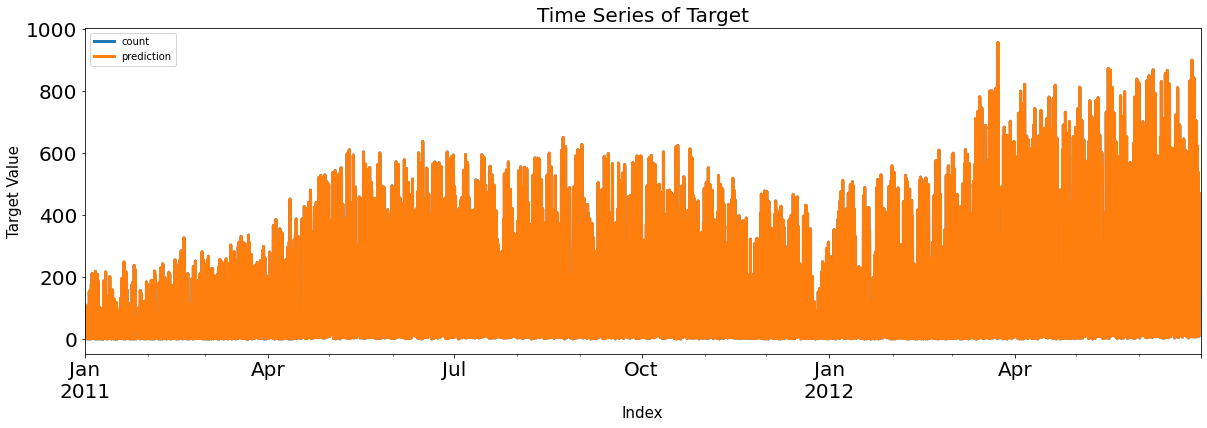

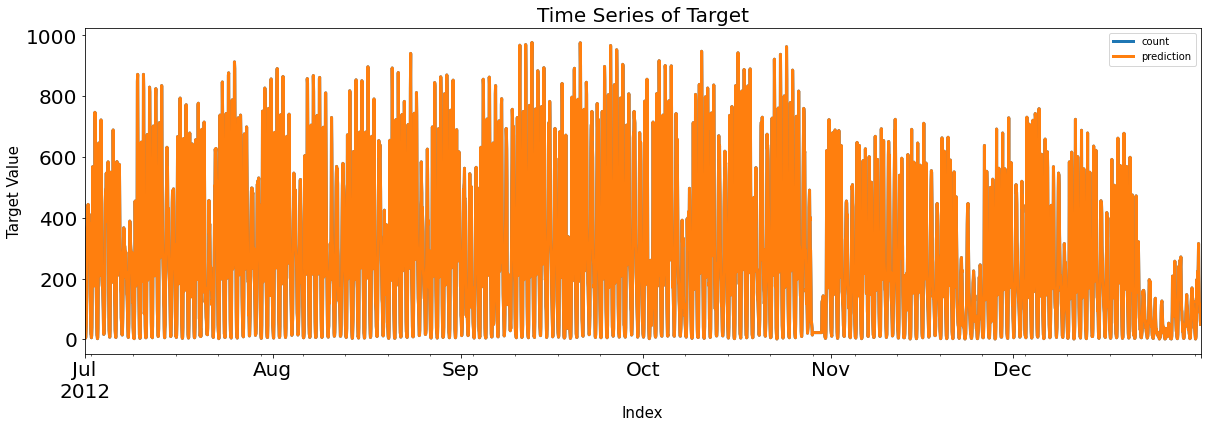

In [9]:
# 결과값, 예측값 만으로 에러를 계산
### Evaluation of 1 pair of set
def evaluation(Y_real, Y_pred, graph_on=False):
    loss_length = len(Y_real.values.flatten()) - len(Y_pred)
    if loss_length != 0:
        Y_real = Y_real[loss_length:]
    if graph_on == True:
        pd.concat([Y_real, pd.DataFrame(Y_pred, index=Y_real.index, columns=['prediction'])], axis=1).plot(kind='line', figsize=(20,6),
                                                                                                           xlim=(Y_real.index.min(),Y_real.index.max()),
                                                                                                           linewidth=3, fontsize=20)
        plt.title('Time Series of Target', fontsize=20)
        plt.xlabel('Index', fontsize=15)
        plt.ylabel('Target Value', fontsize=15)
    MAE = abs(Y_real.values.flatten() - Y_pred).mean()
    MSE = ((Y_real.values.flatten() - Y_pred)**2).mean()
    MAPE = (abs(Y_real.values.flatten() - Y_pred)/Y_real.values.flatten()*100).mean()
    Score = pd.DataFrame([MAE, MSE, MAPE], index=['MAE', 'MSE', 'MAPE'], columns=['Score']).T
    Residual = pd.DataFrame(Y_real.values.flatten() - Y_pred, index=Y_real.index, columns=['Error'])
    return Score, Residual
# Score_tr, Residual_tr = evaluation(Y_train, pred_tr_reg1, graph_on=True)

# test set과 train set 모두 에러를 계산
### Evaluation of train/test pairs
def evaluation_trte(Y_real_tr, Y_pred_tr, Y_real_te, Y_pred_te, graph_on=False):
    Score_tr, Residual_tr = evaluation(Y_real_tr, Y_pred_tr, graph_on=graph_on)
    Score_te, Residual_te = evaluation(Y_real_te, Y_pred_te, graph_on=graph_on)
    Score_trte = pd.concat([Score_tr, Score_te], axis=0)
    Score_trte.index = ['Train', 'Test']
    return Score_trte, Residual_tr, Residual_te
# Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)

# results of evaluations
Score_reg1, Resid_tr_reg1, Resid_te_reg1 = evaluation_trte(Y_train, pred_tr_reg1, Y_test, pred_te_reg1, graph_on=True)
Score_reg1

## **2. Error Analysis**
성능만으로 분석이 끝났다고 보기는 어렵다. 더 중요한 것은 Error를 분석하는 것으로 아래의 셀들은 Error를 어떻게 분석해볼 수 있는지 실습해볼 수 있다.

### Residual Trend 확인
- train set의 error를 시간에 따라 시각화하여 어떤 Trend 특성을 보이는지 확인한다.


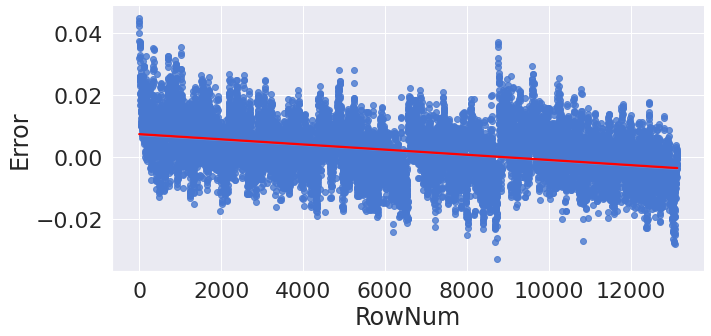

In [14]:
Resid_tr_reg1['RowNum'] = Resid_tr_reg1.reset_index().index
sns.set(palette="muted", color_codes=True, font_scale=2)
sns.lmplot(data=Resid_tr_reg1.iloc[1:], x='RowNum', y='Error',
           fit_reg=True, line_kws={'color': 'red'}, size=5.2, aspect=2, ci=99, sharey=True)

### Residual destribution 확인
- train set의 error의 분포 상태를 시각화하여 어떤 특성을 보이는지 확인한다.


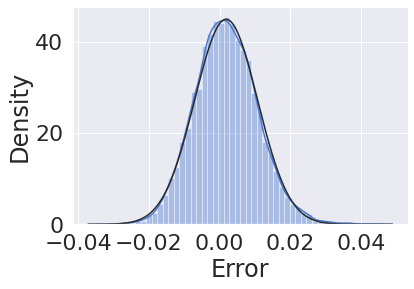

In [15]:
sns.distplot(Resid_tr_reg1['Error'].iloc[1:], norm_hist='True', fit=stats.norm)

### Autocorrelation 확인
- Error의 한 값과 1, 5, 10, 50 시점 뒤의 값의 상관 관계를 확인하기 위한 시각화 결과를 확인한다.
- 가까운 시점의 값들은 양의 상관관계를 어느정도 보이지만 시점이 멀어질수록 독립적인 모습을 확인할 수 있다.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

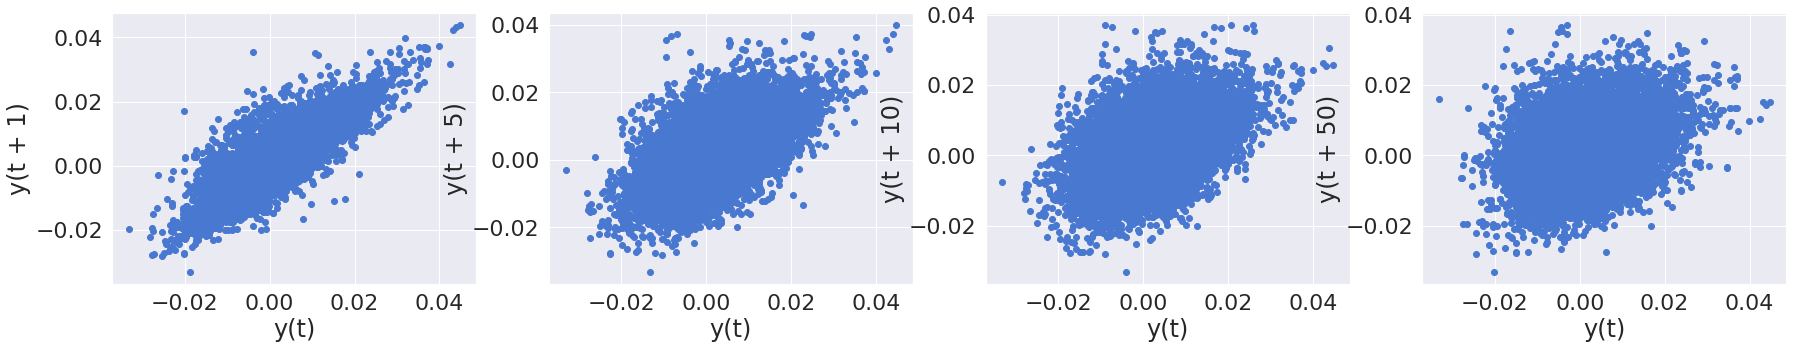

In [16]:
figure, axes = plt.subplots(1, 4, figsize=(30,5))
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=1, ax=axes[0])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=5, ax=axes[1])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=10, ax=axes[2])
pd.plotting.lag_plot(Resid_tr_reg1['Error'].iloc[1:], lag=50, ax=axes[3])

- Autocorrelation(acf)과 PatialAutocorrelation(pacf)를 시각화하여 Error의 특성을 확인한다.
- Autocorrelation이란 값이 어떤 주기마다 데이터가 같은 양상을 보이며 상관 관계를 보이는 것으로 주기성을 확인할 수 있다. 
- 시각화 결과에서 약 24시간 주기로 튀는 값을 확인할 수 있다.

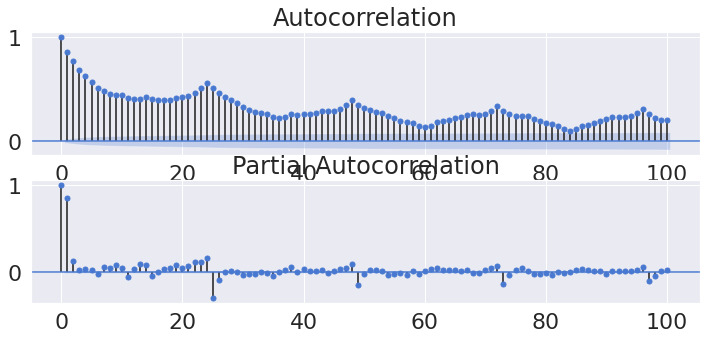

In [17]:
figure, axes = plt.subplots(2,1,figsize=(12,5))
figure = sm.graphics.tsa.plot_acf(Resid_tr_reg1['Error'].iloc[1:], lags=100, use_vlines=True, ax=axes[0])
figure = sm.graphics.tsa.plot_pacf(Resid_tr_reg1['Error'].iloc[1:], lags=100, use_vlines=True, ax=axes[1])

### 정상성 검정
- adf test를 통해 에러의 정상성을 확인한다.
- adf test의 귀무가설은 해당 데이터가 정상성을 갖지 못함 이므로
- 아래 결과와 같이 Test Statisitcs가 Critical Value보다 작은 값을 가지고
- p-value가 0.05보다 작은 값을 가지므로 귀무가설을 기각하여 해당 데이터는 정상성을 가진다고 볼 수 있다.

In [18]:
# Error Analysis(Statistics)
# Checking Stationarity
# Null Hypothesis: The Time-series is non-stationalry
Stationarity = pd.Series(sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[0:4], index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
for key, value in sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[4].items():
    Stationarity['Critical Value(%s)'%key] = value
Stationarity['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Resid_tr_reg1['Error'])[5]
Stationarity = pd.DataFrame(Stationarity, columns=['Stationarity'])
Stationarity

,Stationarity
Test Statistics,-9.98
p-value,0.00
Used Lag,41.00
Used Observations,"13,086.00"
Critical Value(1%),-3.43
Critical Value(5%),-2.86
Critical Value(10%),-2.57
Maximum Information Criteria,"-106,845.57"


### 정규성 검정
- shapiro test를 통해 에러의 정규성을 확인한다.
- 귀무가설은 데이터가 정규성을 가진다는 것으로
- 아래 결과는 p-value가 충분히 작은 값을 가지므로 데이터가 정규성을 갖지 못한다고 볼 수 있다.

In [19]:
# Checking of Normality
# Null Hypothesis: The residuals are normally distributed
Normality = pd.DataFrame([stats.shapiro(Resid_tr_reg1['Error'])], index=['Normality'], columns=['Test Statistics', 'p-value']).T
Normality

,Normality
Test Statistics,0.01
p-value,0.00


### Autocorrelation 검정
- acorr_ljungbox 검정으로 Autocorrelation을 확인한다.
- 귀무가설은 Autocorrelation이 없다는 것으로
- 아래 결과를 보면 lag1부터 50까지 모두 p-value가 높게 나타나 Autocorrelation이 없다고 볼 수 있다.

In [21]:
# Checking for Autocorrelation
# Null Hypothesis: Autocorrelation is absent
Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Resid_tr_reg1['Error'], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                             pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Resid_tr_reg1['Error'], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']
Autocorrelation

,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50)
Test Statistics,0.00,0.01,0.03,0.10
p-value,0.98,1.00,1.00,1.00


### 등분산성 검정
- het_goldfeldquandt를 활용하여 등분산성을 검정한다
- 귀무가설은 해당 데이터가 등분산성을 가진다는 것으로
- 아래의 결과에는 p-value가 작은 값을 가져 residual은 이분산성을 가지는 것을 볼 수 있다.

In [23]:
# Checking Heteroscedasticity
# Null Hypothesis: Error terms are homoscedastic
Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Resid_tr_reg1['Error'], X_train.values, alternative='two-sided')],
                                  index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
Heteroscedasticity

,Heteroscedasticity
Test Statistics,0.00
p-value,0.00
Alternative,two-sided


### Summary
- 위에서 확인한 Residual의 특성들을 하나의 DataFrame으로 확인할 수 있다.
- 이후로는 함수화된 코드를 활용하여 한번에 결과를 확인할 수 있다.

In [24]:
Error_Analysis = pd.concat([Stationarity, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
Error_Analysis = Error_Analysis.loc[['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                                     'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)',
                                     'Maximum Information Criteria'],:]
Error_Analysis

,Stationarity,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.98,0.01,0.00,0.01,0.03,0.10,0.00
p-value,0.00,0.00,0.98,1.00,1.00,1.00,0.00
Alternative,nan,nan,nan,nan,nan,nan,two-sided
Used Lag,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,NaN
Critical Value(5%),-2.86,nan,nan,nan,nan,nan,NaN
Critical Value(10%),-2.57,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,845.57",nan,nan,nan,nan,nan,NaN


In [25]:
### Functionalize
### Error analysis
def stationarity_adf_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data)[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data)[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data)[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    else:
        Stationarity_adf = pd.Series(sm.tsa.stattools.adfuller(Y_Data[Target_name])[0:4],
                                     index=['Test Statistics', 'p-value', 'Used Lag', 'Used Observations'])
        for key, value in sm.tsa.stattools.adfuller(Y_Data[Target_name])[4].items():
            Stationarity_adf['Critical Value(%s)'%key] = value
            Stationarity_adf['Maximum Information Criteria'] = sm.tsa.stattools.adfuller(Y_Data[Target_name])[5]
            Stationarity_adf = pd.DataFrame(Stationarity_adf, columns=['Stationarity_adf'])
    return Stationarity_adf

def stationarity_kpss_test(Y_Data, Target_name):
    if len(Target_name) == 0:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data)[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data)[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    else:
        Stationarity_kpss = pd.Series(sm.tsa.stattools.kpss(Y_Data[Target_name])[0:3],
                                      index=['Test Statistics', 'p-value', 'Used Lag'])
        for key, value in sm.tsa.stattools.kpss(Y_Data[Target_name])[3].items():
            Stationarity_kpss['Critical Value(%s)'%key] = value
            Stationarity_kpss = pd.DataFrame(Stationarity_kpss, columns=['Stationarity_kpss'])
    return Stationarity_kpss

def error_analysis(Y_Data, Target_name, X_Data, graph_on=False):
    for x in Target_name:
        Target_name = x
    X_Data = X_Data.loc[Y_Data.index]

    if graph_on == True:
        ##### Error Analysis(Plot)
        Y_Data['RowNum'] = Y_Data.reset_index().index

        # Stationarity(Trend) Analysis
        sns.set(palette="muted", color_codes=True, font_scale=2)
        sns.lmplot(x='RowNum', y=Target_name, data=Y_Data, fit_reg='True', size=5.2, aspect=2, ci=99, sharey=True)
        del Y_Data['RowNum']

        # Normal Distribution Analysis
        figure, axes = plt.subplots(figsize=(12,8))
        sns.distplot(Y_Data[Target_name], norm_hist='True', fit=stats.norm, ax=axes)

        # Lag Analysis
        length = int(len(Y_Data[Target_name])/10)
        figure, axes = plt.subplots(1, 4, figsize=(12,3))
        pd.plotting.lag_plot(Y_Data[Target_name], lag=1, ax=axes[0])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=5, ax=axes[1])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=10, ax=axes[2])
        pd.plotting.lag_plot(Y_Data[Target_name], lag=50, ax=axes[3])

        # Autocorrelation Analysis
        figure, axes = plt.subplots(2,1,figsize=(12,5))
        sm.tsa.graphics.plot_acf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[0])
        sm.tsa.graphics.plot_pacf(Y_Data[Target_name], lags=100, use_vlines=True, ax=axes[1])

    ##### Error Analysis(Statistics)
    # Checking Stationarity
    # Null Hypothesis: The Time-series is non-stationalry
    Stationarity_adf = stationarity_adf_test(Y_Data, Target_name)
    Stationarity_kpss = stationarity_kpss_test(Y_Data, Target_name)

    # Checking of Normality
    # Null Hypothesis: The residuals are normally distributed
    Normality = pd.DataFrame([stats.shapiro(Y_Data[Target_name])],
                             index=['Normality'], columns=['Test Statistics', 'p-value']).T

    # Checking for Autocorrelation
    # Null Hypothesis: Autocorrelation is absent
    Autocorrelation = pd.concat([pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[0], columns=['Test Statistics']),
                                 pd.DataFrame(sm.stats.diagnostic.acorr_ljungbox(Y_Data[Target_name], lags=[1,5,10,50])[1], columns=['p-value'])], axis=1).T
    Autocorrelation.columns = ['Autocorr(lag1)', 'Autocorr(lag5)', 'Autocorr(lag10)', 'Autocorr(lag50)']

    # Checking Heteroscedasticity
    # Null Hypothesis: Error terms are homoscedastic
    Heteroscedasticity = pd.DataFrame([sm.stats.diagnostic.het_goldfeldquandt(Y_Data[Target_name], X_Data.values, alternative='two-sided')],
                                      index=['Heteroscedasticity'], columns=['Test Statistics', 'p-value', 'Alternative']).T
    Score = pd.concat([Stationarity_adf, Stationarity_kpss, Normality, Autocorrelation, Heteroscedasticity], join='outer', axis=1)
    index_new = ['Test Statistics', 'p-value', 'Alternative', 'Used Lag', 'Used Observations',
                 'Critical Value(1%)', 'Critical Value(5%)', 'Critical Value(10%)', 'Maximum Information Criteria']
    Score.reindex(index_new)
    return Score
# error_analysis(Resid_tr_reg1[1:], ['Error'], X_train, graph_on=True)

- 위의 분석 내용 대로 한번에 Residual을 모두 분석해보았더니 시각화 결과에서 첫번째 데이터가 큰 이상치로 작용하고 있음을 확인할 수 있다.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.98,0.09,0.01,0.00,0.01,0.03,0.10,0.00
p-value,0.00,0.10,0.00,0.98,1.00,1.00,1.00,0.00
Used Lag,41.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,086.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,845.57",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


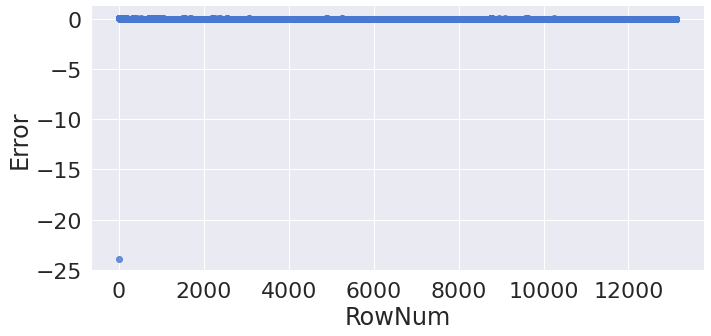

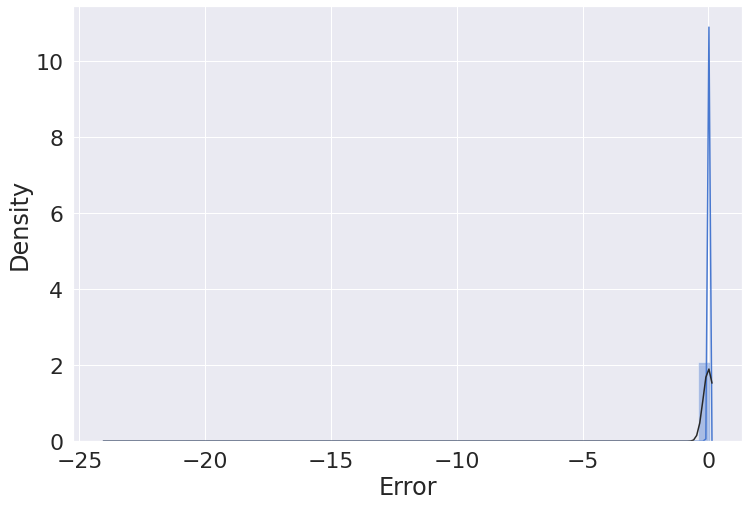

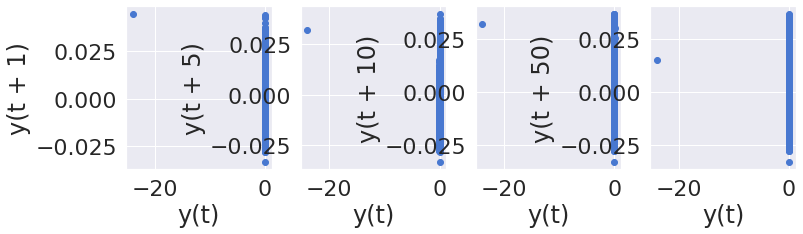

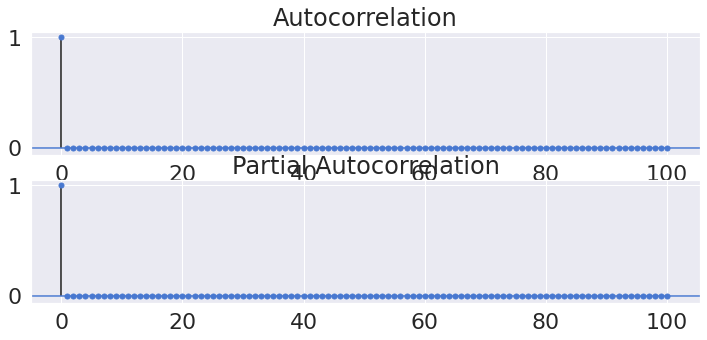

In [27]:
error_analysis(Resid_tr_reg1, ['Error'], X_train, graph_on=True)
# 정상성 / 비정규분포 / 자기상관없음 / 등분산아님

- 첫번째 데이터를 제외한 데이터로 다시 분석해보면 resonable한 결과를 보여주고 검정 결과가 달리짐을 확인할 수 있다.

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.
*c* argument looks like a single numeric RGB o

,Stationarity_adf,Stationarity_kpss,Normality,Autocorr(lag1),Autocorr(lag5),Autocorr(lag10),Autocorr(lag50),Heteroscedasticity
Test Statistics,-9.82,7.52,1.00,"9,615.96","32,903.39","47,262.88","116,653.97",1.61
p-value,0.00,0.01,0.00,0.00,0.00,0.00,0.00,0.00
Used Lag,41.00,41.00,nan,nan,nan,nan,nan,NaN
Used Observations,"13,085.00",nan,nan,nan,nan,nan,nan,NaN
Critical Value(1%),-3.43,nan,nan,nan,nan,nan,nan,NaN
Maximum Information Criteria,"-106,838.93",nan,nan,nan,nan,nan,nan,NaN
Critical Value(10%),nan,0.35,nan,nan,nan,nan,nan,NaN
Alternative,nan,nan,nan,nan,nan,nan,nan,two-sided


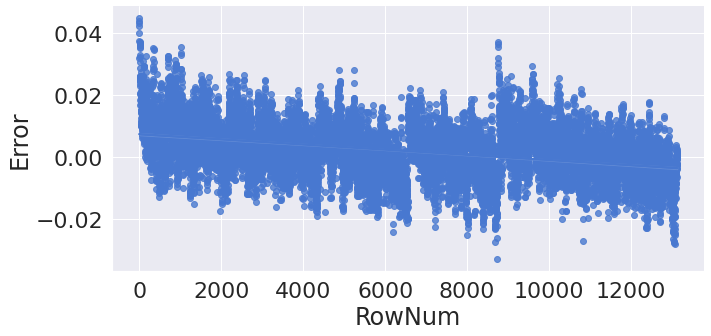

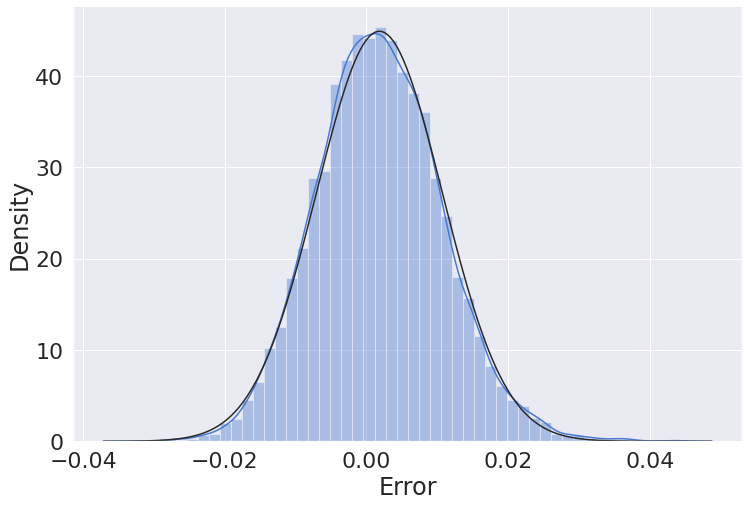

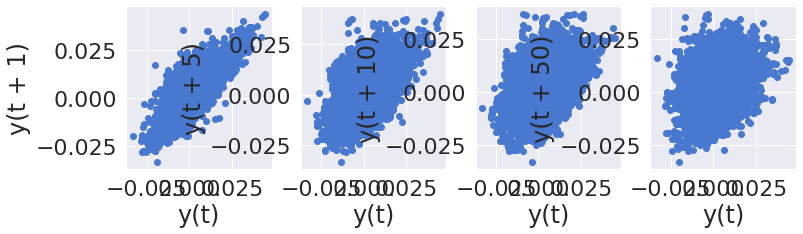

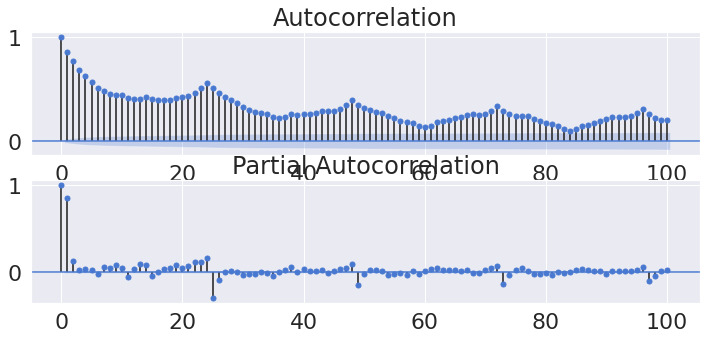

In [26]:
error_analysis(Resid_tr_reg1.iloc[1:], ['Error'], X_train, graph_on=True)
# 정상성(ADf) / 비정상성(KPSS) / 비정규분포 / 자기상관있음 / 등분산아님